Reading EBSCO search data...
	Reading entries from XML file...
	Writing entries to CSV...
	Building daily publication counts...
	Building daily publication sums...
	Converting to Pandas DataFrames....
	Combining DataFrames...
Done.
Creating daily plot:  COVID-19 Publications per Day ...
	Saving plot to 
	 C:\Users\jacob\Desktop\School\Spring 20\Health Economics\COVID19AcademiaDataset\media\COVID-19_Publications_per_Day.png ...
	Printing plot...


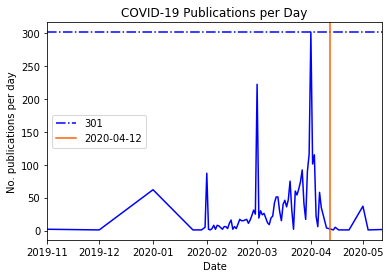

Done.
Creating daily plot:  COVID-19 Total Publications ...
	Saving plot to 
	 C:\Users\jacob\Desktop\School\Spring 20\Health Economics\COVID19AcademiaDataset\media\COVID-19_Total_Publications.png ...
	Printing plot...


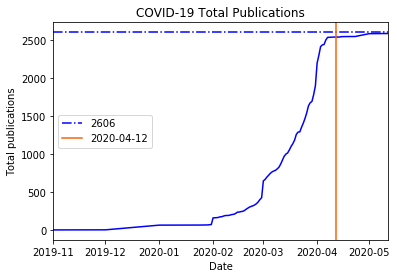

Done.
Building COVID-19 dataset...
	Reading JHU csv files into pandas.DataFrame...
	Building sums across regions...
	Merging, cleaning, and renaming sums...
Done.
Creating daily plot:  Confirmed, Dead, and Recovered Cases Globally ...
	Saving plot to 
	 C:\Users\jacob\Desktop\School\Spring 20\Health Economics\COVID19AcademiaDataset\media\Confirmed,_Dead,_and_Recovered_Cases_Globally.png ...
	Printing plot...


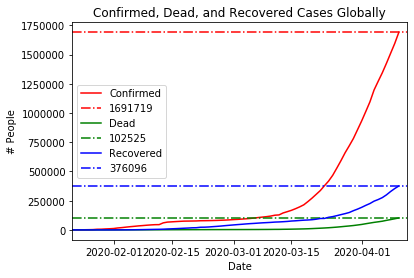

Done.


In [2]:
from ebsco import ebscoDataReader as ebsco
from jhu_covid19 import covidDataReader as covid
from utils import plotData
import os

slash = os.path.sep
# scrapeRawData
path = "ebsco"+slash+"rawData.xml"
ebsco = ebsco.buildDataset(path, "COVID-19");

plotData.plotDaily(ebsco.columns,
            [ebsco.loc[0]],
            ylabel = "No. publications per day", 
            title = "COVID-19 Publications per Day", 
            pltFmt = ['b-'],   
            maxCols = ['b'],       
            todayCol = '#fb6107', 
            saveFmt = 'png')
plotData.plotDaily(ebsco.columns,
            [ebsco.loc[1]],
            ylabel = "Total publications", 
            title = "COVID-19 Total Publications", 
            pltFmt = ['b-'],
            maxCols = ['b'],                   
            todayCol = '#fb6107', 
            saveFmt = 'png')

# Build time series data for confirmed, deaths, recovered cases
path = "jhu_covid19"+slash+"COVID-19"+slash+"csse_covid_19_data"+slash+"csse_covid_19_time_series"+slash
covid = covid.buildDataset(path)
#print(covidData)

plotData.plotDaily(list(covid.index),
            [covid.confirmed, covid.dead, covid.recovered],
            lineLabels = ['Confirmed', 'Dead', 'Recovered'],
            ylabel = "# People", 
            title = "Confirmed, Dead, and Recovered Cases Globally", 
            maxCols = ['r', 'g', 'b'],
            pltFmt = ['r-', 'g-', 'b-'],
            dayLimiter = 0,
            saveFmt = 'png')